In [1]:
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [2]:
# Getting the ticker of the stock that the user wants to work with. 
ticker = input("Please enter the ticker that you want to analyse: ")

In [3]:
# Getting the ticker stock price
stock = yf.Ticker(ticker.upper())
# Querying all the data from a very long time ago. 
stock_history = stock.history(period='20y')
# Dropping the Dividends and the Stock Split column.
stock_histroy = stock_history.drop(['Dividends', 'Stock Splits'], axis=1)

In [27]:
#####################################################
## SPLITTING THE DATASET INTO TRAINING AND TESTING ##
#####################################################
# Using the inbuilt train_test_split function to split the data.
training_data, testing_data = sklearn.model_selection.train_test_split(stock_history, test_size = 1/8, train_size = 7/8, shuffle=False)

<Axes: xlabel='Date'>

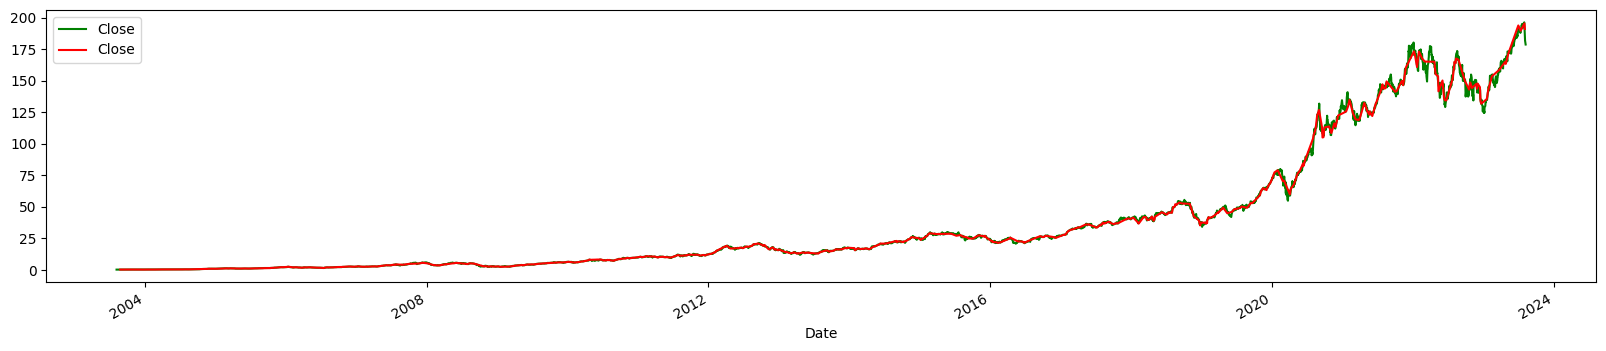

In [28]:
#########################################################################################
## CREATING A PLOT TO SHOW THE STOCK PRICE WE WILL USE TO TRAIN AND THOSE USED TO TEST ##
#########################################################################################
# Plotting the training data
training_data['Close'].plot(figsize=(20,4), legend=True, color='green')
# Plotting the testing data.
testing_data['Close'].plot(figsize=(20,4), legend=True, color='red')
# Adding legends and title

In [ ]:
##########################################################
##